In [76]:
import praw
import pandas as pd
from datetime import datetime

reddit = praw.Reddit(
    client_id="lI82VgjEKpYWdM4I72nvXw",
    client_secret="japMiiHUuFFhkhxeI4kce8ULzpNNVg",
    user_agent="agent xavier/Initial_Ad5864"
)

SUBREDDIT_NAME = "Wimbledon"  # Try "soccer", "nfl", etc.
POST_LIMIT = 50  # Reduce during testing

In [77]:
def scrape_reddit():
    """Collect posts and top-level comments"""
    subreddit = reddit.subreddit(SUBREDDIT_NAME)

    # Get posts
    posts = []
    for post in subreddit.new(limit=POST_LIMIT):
        posts.append({
            "id": post.id,
            "title": post.title,
            "author": str(post.author),
            "timestamp": datetime.fromtimestamp(post.created_utc),
            "text": post.selftext
        })

    # Get comments
    comments = []
    for post in posts:
        submission = reddit.submission(id=post["id"])
        submission.comments.replace_more(limit=0)  # Skip nested comments
        for comment in submission.comments.list():
            comments.append({
                "post_id": post["id"],
                "text": comment.body,
                "author": str(comment.author),
                "timestamp": datetime.fromtimestamp(comment.created_utc)
            })

    return pd.DataFrame(posts), pd.DataFrame(comments)

posts_df, comments_df = scrape_reddit()
print(f"Scraped {len(posts_df)} posts and {len(comments_df)} comments")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Scraped 50 posts and 564 comments


In [78]:
import re

def clean_text(text):
    """Fast text preprocessing for sports comments"""
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)  # Keep basic punctuation
    text = text.lower().strip()
    return text

comments_df['cleaned_text'] = comments_df['text'].apply(clean_text)
posts_df['cleaned_text'] = posts_df['text'].apply(clean_text)

# Preview
print("Original:", comments_df.iloc[0]['text'])
print("Cleaned:", comments_df.iloc[0]['cleaned_text'])

Original: High chance. Second round on the second biggest court. 

Last year on that day were two all British battles, Dart vs. Boulter, Norrie vs. Draper plus 4th seed Zverev and an extra match Fernandez vs. Wozniacki.

Would usually expect at least one top 5 seed men's or women's.
Cleaned: high chance. second round on the second biggest court. 

last year on that day were two all british battles, dart vs. boulter, norrie vs. draper plus 4th seed zverev and an extra match fernandez vs. wozniacki.

would usually expect at least one top 5 seed mens or womens.


In [84]:
from groq import Groq
import json

client = Groq(api_key="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")

def analyze_comment(text):
    """Get aspects and sentiments using LLaMA-3-70B"""
    response = client.chat.completions.create(
        messages=[{
            "role": "user",
            "content": f"""
            Analyze this sports fan comment. Identify specific aspects and their sentiments.
            Return JSON ONLY: {{"aspects": [{{"aspect": "...", "sentiment": "positive|neutral|negative"}}]}}

            Comment: {text}
            """
        }],
        model="llama-3.3-70b-versatile",
        temperature=0.1
    )
    try:
        return json.loads(response.choices[0].message.content)
    except:
        return {"aspects": []}

# Test
test_response = analyze_comment("Djokovic rolls into 10th Wimbledon final")
print(test_response)

{'aspects': [{'aspect': 'Djokovic', 'sentiment': 'positive'}, {'aspect': 'Wimbledon final', 'sentiment': 'positive'}]}


In [85]:
from tqdm import tqdm

# Process first 50 comments for testing
sample_comments = comments_df['cleaned_text'].head(50).tolist()

aspect_results = []
for comment in tqdm(sample_comments):
    result = analyze_comment(comment)
    for aspect in result['aspects']:
        aspect_results.append({
            "comment": comment,
            "aspect": aspect['aspect'],
            "sentiment": aspect['sentiment']
        })

aspects_df = pd.DataFrame(aspect_results)
print(aspects_df.head())

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

                                             comment  \
0  high chance. second round on the second bigges...   
1  high chance. second round on the second bigges...   
2  high chance. second round on the second bigges...   
3  high chance. second round on the second bigges...   
4  yeah i would expect at least one british playe...   

                           aspect sentiment  
0                court assignment   neutral  
1                    match lineup  negative  
2             last year's matches   neutral  
3               seed expectations  negative  
4  expectation of British players   neutral  


In [86]:
# Convert sentiments to numerical scores
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
aspects_df['score'] = aspects_df['sentiment'].map(sentiment_map)

# Group by aspect
aspect_summary = aspects_df.groupby('aspect')['score'].agg(
    avg_score='mean',
    count='size'
).reset_index().sort_values('count', ascending=False)

print(aspect_summary.head(10))

                                aspect  avg_score  count
64                       seat location      0.125      8
87                             tickets      1.000      4
48                  overall experience      1.000      3
79                    team performance      1.000      3
54                               price      0.500      2
31                          experience      1.000      2
0                      2 court tickets      0.000      1
63                        screen setup      1.000      1
70                    seating location      0.000      1
69  seating comparison to Centre Court      1.000      1


In [87]:
# Merge timestamps from original comments
aspects_df = aspects_df.merge(
    comments_df[['cleaned_text', 'timestamp']],
    left_on='comment',
    right_on='cleaned_text'
)

# Hourly sentiment aggregation
aspects_df['hour'] = aspects_df['timestamp'].dt.floor('H')
time_series = aspects_df.groupby(['hour', 'aspect'])['score'].mean().unstack()

time_series.fillna(0, inplace=True)
print(time_series.head())

aspect               2 court tickets  Alcaraz  Centre Court Super Saturday  \
hour                                                                         
2024-11-16 01:00:00              0.0      0.0                          0.0   
2025-01-29 14:00:00              0.0      0.0                          0.0   
2025-01-29 15:00:00              0.0      0.0                          0.0   
2025-01-29 16:00:00              0.0      0.0                          0.0   
2025-01-29 17:00:00              0.0      0.0                          1.0   

aspect               Centre Court tickets  Henman Hill  Super Saturday  \
hour                                                                     
2024-11-16 01:00:00                   0.0          0.0             0.0   
2025-01-29 14:00:00                   0.0          0.0             1.0   
2025-01-29 15:00:00                   0.0          0.0             0.0   
2025-01-29 16:00:00                   0.0          0.0             0.0   
2025-01-2

In [96]:
# Find aspects that make up 90% of all mentions
aspect_summary['cumulative'] = aspect_summary['count'].cumsum() / aspect_summary['count'].sum()
valid_aspects = aspect_summary[aspect_summary['cumulative'] <= 0.9]['aspect'].tolist()

# If still too few, use relative threshold
min_threshold = max(2, int(len(aspects_df)*0.001))  # At least 2 mentions or 0.1% of total
valid_aspects_fallback = aspect_summary[aspect_summary['count'] >= min_threshold]['aspect'].tolist()

valid_aspects = list(set(valid_aspects + valid_aspects_fallback))
filtered_series = time_series[valid_aspects]

print(f"Selected {len(valid_aspects)} aspects:", valid_aspects)
print("\nAspect frequency distribution:")
print(aspect_summary.head(10))

Selected 86 aspects: ['attendance', 'ticket price', 'screen setup', 'Wimbledon experience', 'match variety', 'personal experience or wish', 'tournament organization', 'memory', 'attitude towards missing email', 'stadium size', 'atmosphere', 'receiving a nonsuccess email', 'past decade of not winning', 'obtaining tickets', 'seating on No. 1 Court', 'seat price', "author's attitude towards the post", 'day 4 of the event', "last year's matches", 'ticket prices', 'mywimbledon website', 'court experience', 'court assignment', 'self-description as optimist', "team's chances", 'match lineup', 'week 1 of tennis', 'website view', 'submission process', 'refund policy', 'chance of seeing big names', 'seat pricing', 'seat quality', 'Centre Court Super Saturday', 'team spirit', 'ticket swapping', 'chance of Alcaraz or Djokovic on Court 1', 'draw and scheduling', 'seat location', 'overall tone', 'guaranteed play', 'seating location', 'team performance', 'seed expectations', 'opinion', 'Alcaraz', 'ap

In [97]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize data between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(filtered_series)

# Create sequences for LSTM
def create_sequences(data, window_size=6):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 4  # Hours of historical data to use
X, y = create_sequences(scaled_data, window_size)

# Split 80-20
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Training shape: (13, 4, 86), Test shape: (4, 4, 86)


In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(window_size, len(valid_aspects)), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(len(valid_aspects))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 4, 64)               │          38,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 86)                  │           2,838 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,910 (210.59 KB)

 Trainable params: 53,910 (210.59 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - loss: 0.9813 - val_loss: 0.9242
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.9281 - val_loss: 0.8785
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.8884 - val_loss: 0.8350
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.8483 - val_loss: 0.7887
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.7982 - val_loss: 0.7380
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.7482 - val_loss: 0.6830
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.6968 - val_loss: 0.6258
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.6422 - val_loss: 0.5690
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.5937 - val_loss: 0.5149
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.5454 - val_loss: 0.4645
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4871 - val_loss: 0.4180
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4456 - val_loss: 0.3765


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


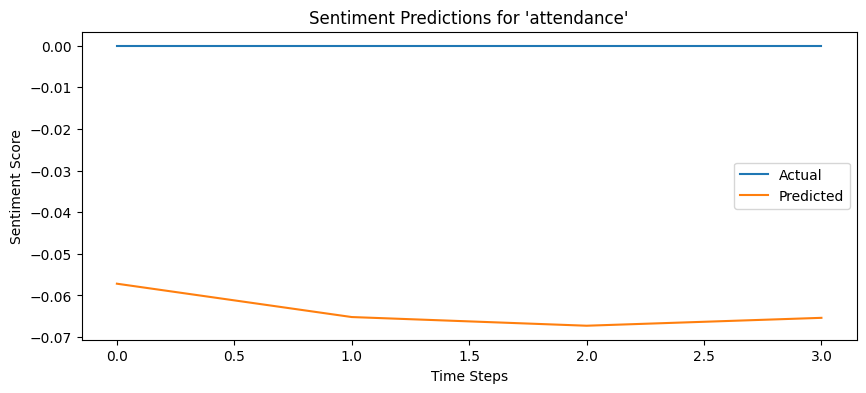

In [100]:
import matplotlib.pyplot as plt

# Predict on test set
predictions = model.predict(X_test)

# Inverse scaling
true_values = scaler.inverse_transform(y_test)
predicted_values = scaler.inverse_transform(predictions)

# Plot first aspect
aspect_index = 0
plt.figure(figsize=(10, 4))
plt.plot(true_values[:, aspect_index], label='Actual')
plt.plot(predicted_values[:, aspect_index], label='Predicted')
plt.title(f"Sentiment Predictions for '{valid_aspects[aspect_index]}'")
plt.xlabel("Time Steps")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

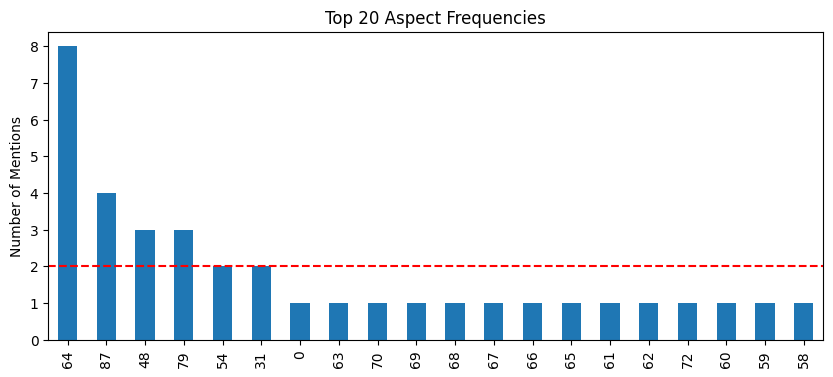

In [103]:
# Visualize aspect frequency
plt.figure(figsize=(10,4))
aspect_summary['count'][:20].plot(kind='bar')
plt.title("Top 20 Aspect Frequencies")
plt.ylabel("Number of Mentions")
plt.axhline(y=min_threshold, color='r', linestyle='--', label='Minimum Threshold')
plt.show()